# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import AutoMinorLocator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
sns.set()

# Méthodes

In [2]:
def convert_false_to_nan(df):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    for col in df.columns:
        temp_miss = df[df[col].isin([False])]
        if len(temp_miss) > 0:
            print("Dans la colonne", col, ", il y a", len(temp_miss), "valeurs à False. Nous les passons à NaN pour les traiter plus facilement.")
            df.loc[df[col]==False, col] = np.nan
    
    result = df
    return result

In [3]:
def filter_col_by_mising_data_pct(df, pct_min=0, pct_max=100):
    result = pd.DataFrame()
    print("Le DataFrame à filtrer présente", len(df), "lignes et", len(df.columns), "colonnes.")
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    print("La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de", pct_min, "% inclu à", pct_max, "% exclu.")
    # extraction des colonnes remplissant la condition de filtrage
    tot_list_col = round(df.isnull().mean()*100, 4).sort_values(ascending=False)
    tot_list_col = pd.DataFrame(tot_list_col, columns = ["%"])
    remain_list_col = tot_list_col.loc[(tot_list_col["%"] >= pct_min) & (tot_list_col["%"] < pct_max), :]
    nb_col_remained = len(remain_list_col)
    nb_col_removed = len(tot_list_col) - nb_col_remained
    print("Après filtrage, il reste", nb_col_remained, "colonnes dans le DataFrame.")
    print("Il y a eu suppression de", nb_col_removed, "colonnes, soit", round(nb_col_removed/len(tot_list_col)*100, 2), "% des colonnes.")
    
    # test sur le nb de colonnes restantes
    if len(remain_list_col) == 0:
        print("Le filtre est trop bas. Il n'y a plus de colonnes à exploiter.")
        return result
    
    # renvoyer le même dataset avec uniquement les colonnes filtrées
    result = df[remain_list_col.index]
    return result

In [4]:
def remove_empty_columns(df):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    print("Appel de la méthode filter_col_by_mising_data_pct() pour supprimer les colonnes vides.")
    result = filter_col_by_mising_data_pct(df)
    return result    

In [5]:
def split_data_num_categ(df):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

In [6]:
# pour afficher les pourcentages et les libellés pour les parts > 5%
limit_perc = 5
def show_perc(pct):
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

# Chargement du dataset

Il y avait un problème de données à cheval sur plusieurs lignes. Un script a permis de corriger le problème. Voici le fichier corrigé en entrée.

In [7]:
# Le séparateur dans le dataset est la tabulation
raw_data = pd.read_csv("fr.openfoodfacts.org.products_c1.csv", encoding='utf-8', sep='\t')

/tmp/ipykernel_8644/2650904854.py:2: DtypeWarning: Columns (0,19,20,24,25,26,28,35,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("fr.openfoodfacts.org.products_c1.csv", encoding='utf-8', sep='\t')


In [8]:
print("Le dataset présente", raw_data.shape[0], "lignes et", raw_data.shape[1], "colonnes")

Le dataset présente 320749 lignes et 162 colonnes


In [9]:
# Les valeurs à False seront mise à NaN pour permettre le netoyage
# data_w_false = convert_false_to_nan(raw_data)

<AxesSubplot: >

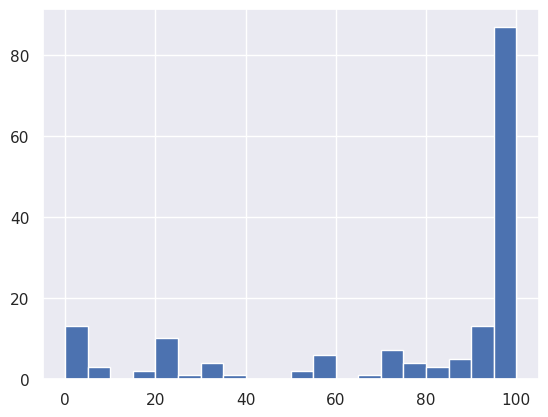

In [10]:
valeurs_manquantes = round(raw_data.isnull().mean()*100, 4).sort_values(ascending=False)
missing_val_df = pd.DataFrame(valeurs_manquantes, columns = ["%"])
missing_val_df["%"].hist(bins=20)

In [11]:
miss_val_90 = missing_val_df.loc[missing_val_df["%"]>=90, :]
print("Les colonnes ayant plus de 90% de valeurs manquantes sont au nombre de", len(miss_val_90), "soit,", round(len(miss_val_90)/raw_data.shape[1]*100, 2), "% des colonnes.")

Les colonnes ayant plus de 90% de valeurs manquantes sont au nombre de 100 soit, 61.73 % des colonnes.


<AxesSubplot: >

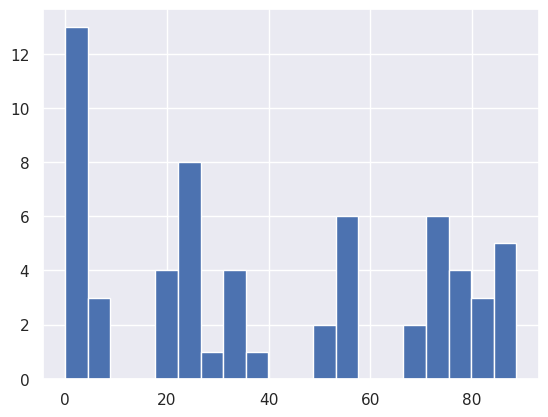

In [12]:
valeurs_manquantes = round(raw_data.isnull().mean()*100, 4).sort_values(ascending=False)
missing_val_df = pd.DataFrame(valeurs_manquantes, columns = ["%"])
missing_val_df.loc[missing_val_df["%"]<90, "%"].hist(bins=20)

# Nettoyage

## Suppressions Lignes

In [13]:
# le nutriscore sera notre target, donc on peut supprimer toutes les lignes n'ayant pas de nutriscore renseigné
data_w_target = raw_data.loc[raw_data["nutrition-score-fr_100g"].notnull(), :]
print("Il y a", raw_data.shape[0] - data_w_target.shape[0], "lignes sans nutri-score de renseigné, soit", round((1-data_w_target.shape[0]/raw_data.shape[0])*100, 2), "% des données.")
data_w_target.reset_index(drop=True)

Il y a 99516 lignes sans nutri-score de renseigné, soit 31.03 % des données.


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
1,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
3,16124,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055711,2017-03-09T10:35:11Z,1489055712,2017-03-09T10:35:12Z,Organic Muesli,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,NaN,NaN
4,16872,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055650,2017-03-09T10:34:10Z,1489055651,2017-03-09T10:34:11Z,Zen Party Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221228,9787461062105,http://world-fr.openfoodfacts.org/produit/9787...,usda-ndb-import,1489092300,2017-03-09T20:45:00Z,1489092300,2017-03-09T20:45:00Z,Natural Cassava,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN
221229,9847548283004,http://world-fr.openfoodfacts.org/produit/9847...,drmalabar,1437817626,2015-07-25T09:47:06Z,1442237848,2015-09-14T13:37:28Z,Tartines craquantes bio au sarrasin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,-4.0,NaN,NaN
221230,9900000000233,http://world-fr.openfoodfacts.org/produit/9900...,kiliweb,1491079938,2017-04-01T20:52:18Z,1491079939,2017-04-01T20:52:19Z,Amandes,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
221231,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,1367163039,2013-04-28T15:30:39Z,1371690556,2013-06-20T01:09:16Z,Thé vert Earl grey,thé bio équitable,50 g,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN


## Suppressions colonnes

Les colonnes étant complètement vides ne seront pas utilisées dans notre étude. Nous allons donc les supprimer.

In [14]:
# on appelle la méthode permettant de supprimer les colonnes vides
data_filt_100p = remove_empty_columns(data_w_target)

Appel de la méthode filter_col_by_mising_data_pct() pour supprimer les colonnes vides.
Le DataFrame à filtrer présente 221233 lignes et 162 colonnes.
La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de 0 % inclu à 100 % exclu.
Après filtrage, il reste 135 colonnes dans le DataFrame.
Il y a eu suppression de 27 colonnes, soit 16.67 % des colonnes.


## Sélection des colonnes pertinentes métier

Après étude de la problématique métier, j'ai fait la liste des colonnes ayant une pertinence dans notre analyse.  
 - Identification : 
 - Target : pour le calcul de notre modèle
 - Obligatoire : ce sont les éléments qui sont obligatoirement sur les étiquettes des produits d'après les lois européennes
 - Possible : ce sont les éléments qui sont possiblement sur les étiquettes des produits d'après les lois européennes
 - Pertiente : ce sont les éléments que je trouve pertient pour notre étude
 - Vitamines : 
 - Sels minéraux : 

In [15]:
col_id = ['code', 'product_name', 'generic_name', 'nutrition_grade_fr', 'countries_fr']
col_target = ['nutrition-score-fr_100g']
col_mandatory = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g']
col_possible = ['monounsaturated-fat_100g', 'polyunsaturated-fat_100g', "polyols_100g", "starch_100g", "fiber_100g"]
col_pertinents = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'fruits-vegetables-nuts_100g']
col_vitamins = ['vitamin-a_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g',
                'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'vitamin-b12_100g', 'biotin_100g',
                 'pantothenic-acid_100g']
col_minerals = ['potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g',
                 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g', 'selenium_100g', 'chromium_100g',
                 'molybdenum_100g', 'iodine_100g']
print("D'après les lois européennes, il y a", len(col_mandatory), "colonnes obligatoires sur une étiquette.")
print("Optionnellement, il y a", len(col_possible), "colonnes.")
print("Il y a", len(col_pertinents), "colonnes pertinentes selon moi.")
print("Il y a optionnellement", len(col_vitamins), "colonnes avec les vitamines.")
print("Et pour finir, il y a optionnellement", len(col_minerals), "colonnes avec les sels minéraux.")
col_to_keep = col_id + col_target + col_mandatory + col_possible + col_pertinents + col_vitamins + col_minerals
print("On va donc travailler exclusivement avec ces", len(col_to_keep), "colonnes, soit", round(len(col_to_keep)/len(raw_data.columns)*100, 2), "% des colonnes.")
data_col_keep = data_filt_100p[col_to_keep]
print("Après filtrage, il reste", len(data_col_keep.columns), "colonnes dans le DataFrame.")

D'après les lois européennes, il y a 7 colonnes obligatoires sur une étiquette.
Optionnellement, il y a 5 colonnes.
Il y a 4 colonnes pertinentes selon moi.
Il y a optionnellement 13 colonnes avec les vitamines.
Et pour finir, il y a optionnellement 14 colonnes avec les sels minéraux.
On va donc travailler exclusivement avec ces 49 colonnes, soit 30.25 % des colonnes.
Après filtrage, il reste 49 colonnes dans le DataFrame.


## Lignes dupliquées

In [16]:
# identification et suppressions des lignes dupliquées
nb_lignes_dupli = data_col_keep.duplicated().sum()
print("Il y a", nb_lignes_dupli, "lignes dupliquées dans ce dataset, soit", round(nb_lignes_dupli/len(raw_data)*100, 3), "% du dataset.")
data_dupli_drop = data_col_keep.drop_duplicates().reset_index(drop=True)
print("On a supprimé les lignes dupliquées. Il reste", len(data_dupli_drop), "lignes dans le dataset.")

Il y a 10 lignes dupliquées dans ce dataset, soit 0.003 % du dataset.
On a supprimé les lignes dupliquées. Il reste 221223 lignes dans le dataset.


## Séparation données numériques et catégoricielles

In [17]:
# On regare la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(data_dupli_drop)

Voici la répartition des colonnes par type de données :
numeric : 44 colonnes.
category : 5 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


## Valeurs manquantes

In [18]:
# A partir de là, nos données auront une structure fixe
data = data_dupli_drop
print("Notre dataset d'étude présente", data.shape[0], "lignes et", data.shape[1], "colonnes")
print("Par rapport à notre dataset brut, on a supprimé", round((1-data.shape[0]/raw_data.shape[0])*100, 2), "% de lignes et", round((1-data.shape[1]/raw_data.shape[1])*100, 2), "% de colonnes.")
raw_data = ""

Notre dataset d'étude présente 221223 lignes et 49 colonnes
Par rapport à notre dataset brut, on a supprimé 31.03 % de lignes et 69.75 % de colonnes.


### Traitement données catégoricielles

In [19]:
miss_categ = round(data[data_categ.columns].isnull().mean()*100, 4).sort_values(ascending=False)
miss_categ_df = pd.DataFrame(miss_categ, columns = ["%"])
print(miss_categ_df)

                          %
generic_name        82.3847
product_name         1.2417
countries_fr         0.0258
code                 0.0000
nutrition_grade_fr   0.0000


In [20]:
# si pas de product name, prendre generic name
mask_gen_to_prod = (data["product_name"].isnull()) & (data["generic_name"].notnull())
data.loc[mask_gen_to_prod, "product_name"] = data["generic_name"]
# sinon, prendre code
mask_code_to_prod = (data["product_name"].isnull()) & (data["code"].notnull())
data.loc[mask_code_to_prod, "product_name"] = data["code"]

In [21]:
data.loc[data["countries_fr"].isnull(),"countries_fr"] = "Autre"

### Traitement données numériques

In [22]:
miss_num = round(data[data_num.columns].isnull().mean()*100, 4).sort_values(ascending=False)
miss_num_df = pd.DataFrame(miss_num, columns = ["%"])
print(miss_num_df)

                                               %
molybdenum_100g                          99.9968
chromium_100g                            99.9928
fluoride_100g                            99.9788
chloride_100g                            99.9711
iodine_100g                              99.8965
starch_100g                              99.8861
biotin_100g                              99.8748
polyols_100g                             99.8219
vitamin-k_100g                           99.6063
selenium_100g                            99.5715
vitamin-e_100g                           99.4589
manganese_100g                           99.3183
pantothenic-acid_100g                    99.2103
copper_100g                              99.0878
fruits-vegetables-nuts_100g              98.7221
zinc_100g                                98.4075
vitamin-b12_100g                         98.1530
vitamin-b9_100g                          97.7353
magnesium_100g                           97.5712
phosphorus_100g     

On fait l'approximation de mettre toutes les valeurs numériques à 0 car si elles ne sont pas renseignées, c'est souvent parce qu'elles n'existent pas sur l'étiquette.

In [23]:
# toutes les valeurs numériques ont remplies à 0
for col in data_num.columns:
    data[col].fillna(0, inplace=True)

## Outliers

In [24]:
data[data_num.columns].describe()

,nutrition-score-fr_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,...,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g
count,221223.000000,2.212230e+05,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,...,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,2.212230e+05,221223.000000,2.212230e+05,2.212230e+05,2.212230e+05
mean,9.164639,1.195217e+03,12.309933,4.965493,30.596926,15.010375,7.768934,1.638742,0.659043,0.455032,...,0.001888,0.011057,0.000116,0.000051,0.000020,7.376783e-07,0.000016,1.379204e-07,1.069509e-09,3.157486e-07
std,9.055873,6.986475e+03,15.967228,7.657740,28.617299,21.175718,8.123507,137.352639,4.159129,2.895605,...,0.134368,2.010005,0.010429,0.037997,0.002372,1.553570e-04,0.007594,6.378419e-05,2.646401e-07,2.458445e-05
min,-15.000000,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,-3.570000,0.000000,0.000000,0.000000,...,-0.000260,0.000000,0.000000,-6.896552,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,4.500000e+02,0.000000,0.000000,4.700000,1.270000,1.900000,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,10.000000,1.192000e+03,5.360000,1.790000,19.610000,5.000000,5.700000,0.645160,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,16.000000,1.715000e+03,20.000000,7.140000,57.140000,23.035000,10.710000,1.361440,0.000000,0.000000,...,0.001290,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
max,40.000000,3.251373e+06,714.290000,550.000000,209.380000,3520.000000,430.000000,64312.800000,557.140000,75.000000,...,50.000000,657.143000,4.000000,16.483516,0.700000,5.000000e-02,3.571429,3.000000e-02,1.040000e-04,5.000000e-03


On observe différents outliers.  
Concernant les valeurs négatives, seul le nutri-score peut avoir cette valeur. Pour toutes les autres, on remplace la valeur négative par zéro.  
Concernant les valeurs maximum, les taux pour 100 g ne devraient pas dépasser 100. C'est une certitude pour les composants de base. En revanche, pour les vitamines et les Sels minéraux, il est possible que l'unité de mesure soit le µg. Une valeur supérieur à 100 est donc envisageable. Nous les laisserons donc.

In [25]:
# toutes les valeurs négatives, sauf le nutriscore seront calées à 0
col_outliers_1 = col_mandatory + col_possible + col_pertinents + col_vitamins + col_minerals
nb_num_neg = 0
for col in col_outliers_1:
    temp_nb_num_neg = data.loc[data[col]<0, :]
    nb_num_neg += len(temp_nb_num_neg)
    data.loc[data[col]<0, col] = 0  
print("Toutes les valeurs négatives sont calées à 0. Elles représentent", nb_num_neg, "valeurs, soit", round(nb_num_neg/len(data)*100, 3), "% du dataset d'étude.")

# toutes les valeurs supérieures à 100, sauf les vitamines et minéraux (unités en µg parfois) et la valeur énergétique
nb_num_sup_cent_ok = 0
col_outliers_2 = col_mandatory[1:] + col_possible + col_pertinents
for col in col_outliers_2:
    temp_nb_num_sup_cent_ok = data.loc[data[col]>100, :]
    nb_num_sup_cent_ok += len(temp_nb_num_sup_cent_ok)
    data.loc[data[col]>100, col] = 100
print("Toutes les valeurs supérieures à 100 sont calées à 100 quand c'est sûr. Elles représentent", nb_num_sup_cent_ok, "valeurs, soit", round(nb_num_sup_cent_ok/len(data)*100, 2), "% du dataset d'étude.")

Toutes les valeurs négatives sont calées à 0. Elles représentent 10 valeurs, soit 0.005 % du dataset d'étude.
Toutes les valeurs supérieures à 100 sont calées à 100 quand c'est sûr. Elles représentent 82 valeurs, soit 0.04 % du dataset d'étude.


In [26]:
# outliers qu'on laissera ainsi à cause des différentes unités de mesure
nb_num_sup_cent_maybe = 0
col_outliers_3 = col_vitamins + col_minerals
for col in col_outliers_3:
    temp_nb_num_sup_cent_maybe = data.loc[data[col]>100, :]
    nb_num_sup_cent_maybe += len(temp_nb_num_sup_cent_maybe)
print("Il y a cependant, des valeurs supérieures à 100 qu'on laissera ainsi. Elles représentent", nb_num_sup_cent_maybe, "valeurs, soit", round(nb_num_sup_cent_maybe/len(data)*100, 3), "% du dataset d'étude.")    

Il y a cependant, des valeurs supérieures à 100 qu'on laissera ainsi. Elles représentent 17 valeurs, soit 0.008 % du dataset d'étude.


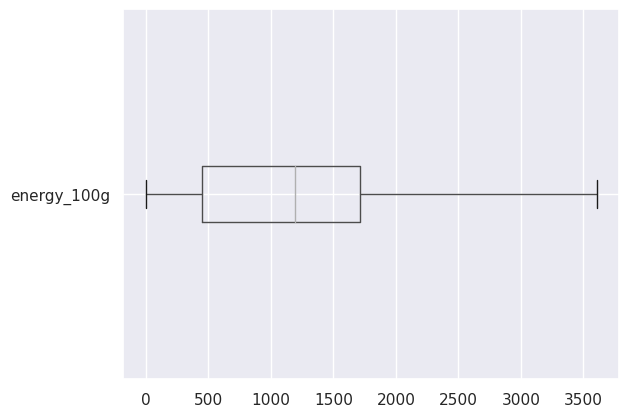

In [27]:
# autre outliers energy
data.boxplot(column="energy_100g", vert=False, showfliers=False)
plt.show()

In [28]:
# On cale les outliers max de l'énergie pour avoir quelque chose d'exploitable
quartiles = [np.nanpercentile(data["energy_100g"], p) for p in [25, 75]]
IQR = quartiles[1]-quartiles[0]
borne_max = 1.5*IQR+quartiles[1]
print("IQR : ", IQR)
print("borne max : ", borne_max)

max_possible = 3700
nb_energy_sup_max = len(data.loc[data["energy_100g"]>max_possible, :])
print("Nous modifions la valeur de l'énergie pour", nb_energy_sup_max, "lignes, soit", round(nb_energy_sup_max/len(data)*100, 2), "% du dataset d'étude.")    
data.loc[data["energy_100g"]>borne_max, "energy_100g"] = max_possible

IQR :  1265.0
borne max :  3612.5
Nous modifions la valeur de l'énergie pour 442 lignes, soit 0.2 % du dataset d'étude.


In [29]:
data[data_num.columns].describe()

,nutrition-score-fr_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,...,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g
count,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,...,221223.000000,221223.000000,221223.000000,221223.000000,221223.000000,2.212230e+05,221223.000000,2.212230e+05,2.212230e+05,2.212230e+05
mean,9.164639,1176.591605,12.305863,4.962962,30.595569,14.994811,7.767458,1.258245,0.656977,0.455032,...,0.001888,0.011057,0.000116,0.000083,0.000020,7.376783e-07,0.000016,1.379204e-07,1.069509e-09,3.157486e-07
std,9.055873,763.007574,15.880124,7.562392,28.612192,19.820681,8.076114,4.220782,3.992887,2.895605,...,0.134368,2.010005,0.010429,0.035054,0.002372,1.553570e-04,0.007594,6.378419e-05,2.646401e-07,2.458445e-05
min,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,450.000000,0.000000,0.000000,4.700000,1.270000,1.900000,0.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,10.000000,1192.000000,5.360000,1.790000,19.610000,5.000000,5.700000,0.645160,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,16.000000,1715.000000,20.000000,7.140000,57.140000,23.035000,10.710000,1.361440,0.000000,0.000000,...,0.001290,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
max,40.000000,3700.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,75.000000,...,50.000000,657.143000,4.000000,16.483516,0.700000,5.000000e-02,3.571429,3.000000e-02,1.040000e-04,5.000000e-03


# Machine Learning

## Régression linéaire

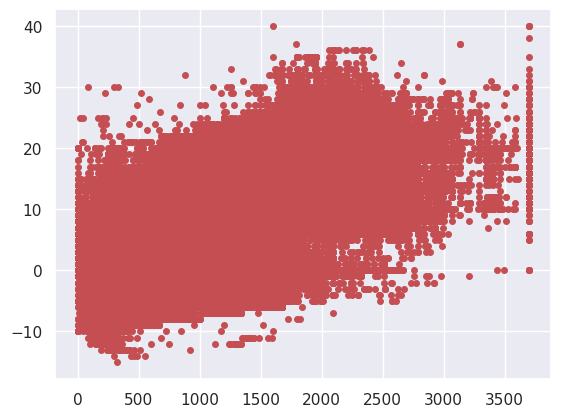

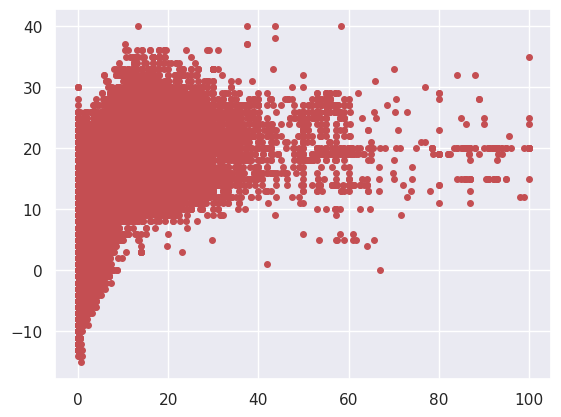

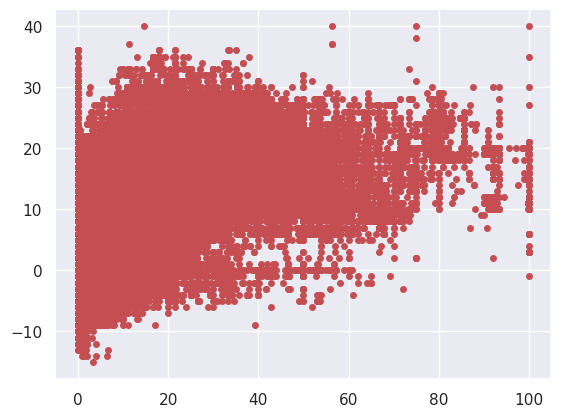

In [30]:
# target nutriscore et 1 données d'entrée energy_100g
for col in ['energy_100g', 'saturated-fat_100g', 'fat_100g']:
    plt.plot(data[col], data['nutrition-score-fr_100g'], 'ro', markersize=4)
    plt.show()

In [31]:
# On décompose le dataset et on le transforme en matrices pour pouvoir effectuer notre calcul
X = np.matrix([np.ones(data.shape[0]), data['energy_100g'].values]).T
y = np.matrix(data['nutrition-score-fr_100g']).T
# On effectue le calcul exact du paramètre theta
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print(theta)

[[0.28923896]
 [0.00754331]]


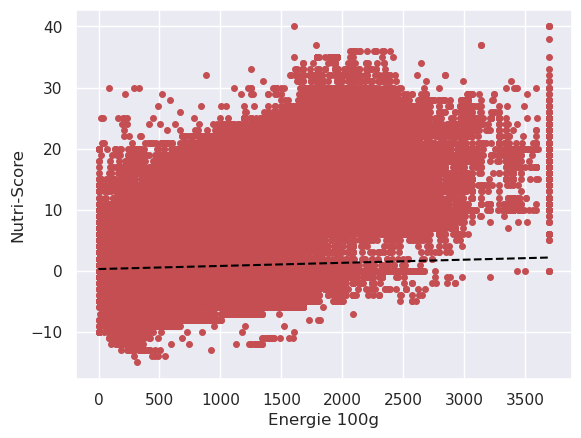

In [32]:
plt.xlabel("Energie 100g")
plt.ylabel('Nutri-Score')
plt.plot(data['energy_100g'], data['nutrition-score-fr_100g'], 'ro', markersize=4)
# On affiche la droite entre 0 et 250
plt.plot([0,3700], [theta.item(0),theta.item(0) + 250 * theta.item(1)], linestyle='--', c='#000000')
plt.show()

[[5.41087927]
 [0.75635478]]


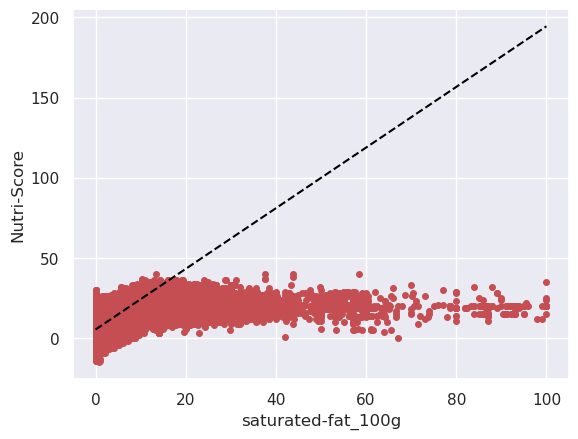

[[5.41728784]
 [0.30451757]]


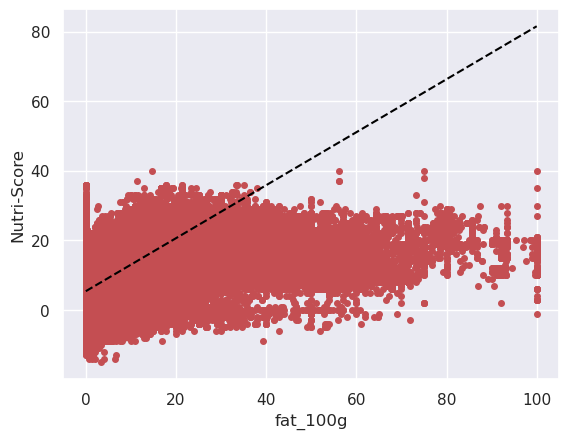

In [33]:
for col in ['saturated-fat_100g', 'fat_100g']:
    # On décompose le dataset et on le transforme en matrices pour pouvoir effectuer notre calcul
    X = np.matrix([np.ones(data.shape[0]), data[col].values]).T
    y = np.matrix(data['nutrition-score-fr_100g']).T
    # On effectue le calcul exact du paramètre theta
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    print(theta)
    plt.xlabel(col)
    plt.ylabel('Nutri-Score')
    plt.plot(data[col], data['nutrition-score-fr_100g'], 'ro', markersize=4)
    # On affiche la droite entre 0 et 250
    plt.plot([0,100], [theta.item(0),theta.item(0) + 250 * theta.item(1)], linestyle='--', c='#000000')
    plt.show()

## ML

energy_100g', 'saturated-fat_100g', 'fat_100g', 'nutrition-score-fr_100g', nutrition_grade_fr

In [34]:
code = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5}
data['nutrition_grade_fr'] =data['nutrition_grade_fr'].replace(code).astype(np.float64)

<AxesSubplot: xlabel='energy_100g', ylabel='nutrition-score-fr_100g'>

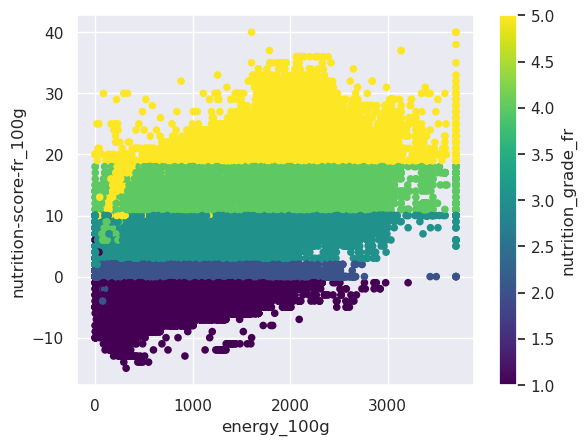

In [35]:
# On affiche les données nettoyées
data.plot.scatter("energy_100g", "nutrition-score-fr_100g", c="nutrition_grade_fr", colormap='viridis')

<AxesSubplot: xlabel='saturated-fat_100g', ylabel='nutrition-score-fr_100g'>

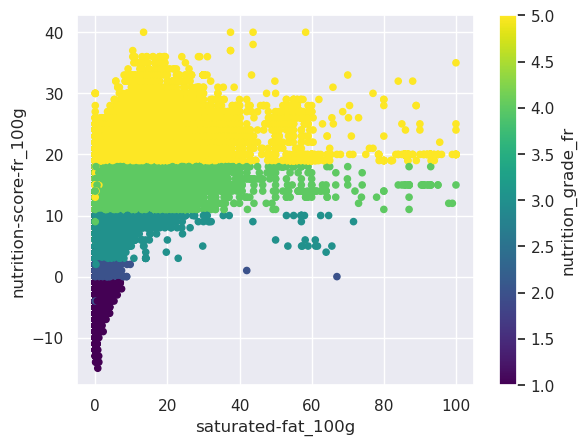

In [56]:
# On affiche les données nettoyées
data.plot.scatter("saturated-fat_100g", "nutrition-score-fr_100g", c="nutrition_grade_fr", colormap='viridis')

In [36]:
# ax1 = sns.violinplot("nutrition_grade_fr", "energy_100g", data=data, hue='nutrition_grade_fr')
# ax1.minorticks_on()
# ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
# ax1.grid(which='minor', axis='x', linewidth=1)

In [37]:
# ax1 = sns.violinplot("nutrition_grade_fr", "saturated-fat_100g", data=data, hue='nutrition_grade_fr')
# ax1.minorticks_on()
# ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
# ax1.grid(which='minor', axis='x', linewidth=1)

In [38]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure().gca(projection='3d')

# # Pour faciliter la visualisation, on va changer la valeur de l'arrondissement (10)
# tmp_arr = data['nutrition_grade_fr'][:]

# fig.scatter(tmp_arr, data['energy_100g'], data['nutrition-score-fr_100g'], c=tmp_arr, cmap="viridis")
# plt.show()

## Régr Lin 2

In [39]:
xtrain, xtest, ytrain, ytest = train_test_split(data[["energy_100g", "nutrition_grade_fr"]], data[["nutrition-score-fr_100g"]], test_size=0.3)

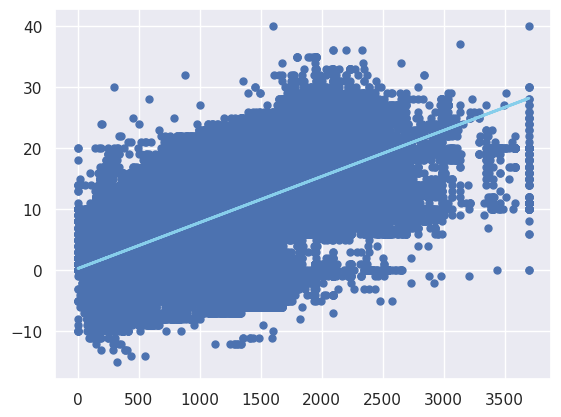

In [40]:
lr = LinearRegression()
lr_baseline = lr.fit(xtrain[["energy_100g"]], ytrain)
baseline_pred = lr_baseline.predict(xtest[["energy_100g"]])

plt.plot(xtest[["energy_100g"]], ytest, 'bo', markersize = 5)
plt.plot(xtest[["energy_100g"]], baseline_pred, color="skyblue", linewidth = 2)

In [41]:
def sumsq(x,y):
    return sum((x - y)**2)

def r2score(pred, target):
    return 1 - sumsq(pred, target) / sumsq(target, np.mean(target))

score_bl = r2score(baseline_pred[:,0], ytest['nutrition-score-fr_100g'])

print(score_bl)

0.40434162407592444


In [42]:
lrs = []
for i in np.unique(xtrain["nutrition_grade_fr"]):
    
    # On génère un jeu de données par arrondissement
    tr_arr = xtrain['nutrition_grade_fr']==i
    te_arr = xtest['nutrition_grade_fr']==i
    
    xtrain_arr = xtrain[tr_arr]
    ytrain_arr = ytrain[tr_arr]

    xtest_arr = xtest[te_arr]
    ytest_arr = ytest[te_arr]

    lr = LinearRegression()
    lr.fit(xtrain_arr[["energy_100g"]], ytrain_arr)
    lrs.append(lr)

In [43]:
print(lrs)

[LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression()]


## KNN

In [44]:
print(data.shape)

(221223, 49)


In [45]:
sample = np.random.randint(221223, size=80000)
neo_data = data.iloc[sample]

In [46]:
print(neo_data.shape)

(80000, 49)


In [47]:
# col_mandatory + col_possible + col_pertinents + col_vitamins + col_minerals
col_mandatory = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g']
col_possible = ['monounsaturated-fat_100g', 'polyunsaturated-fat_100g', "polyols_100g", "starch_100g", "fiber_100g"]
perf = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'salt_100g'] + ["fiber_100g"]
my_data = neo_data[perf]# + col_vitamins]
my_target = neo_data[["nutrition-score-fr_100g"]]['nutrition-score-fr_100g']
my_target = neo_data[["nutrition_grade_fr"]]['nutrition_grade_fr']

In [48]:
xtrain, xtest, ytrain, ytest = train_test_split(my_data, my_target, train_size=0.8)

In [49]:
model = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance', p=1, leaf_size=40, metric='minkowski')

In [50]:
model.fit(xtrain, ytrain)

KNeighborsClassifier(leaf_size=40, n_neighbors=10, p=1, weights='distance')

In [51]:
error = 1 - model.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.174250


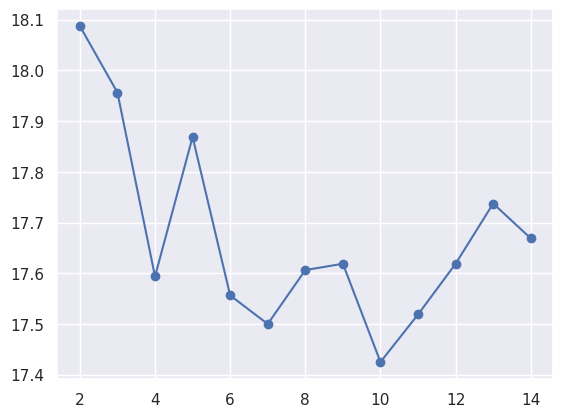

In [52]:
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k, weights='distance', p=1, leaf_size=40, metric='minkowski')
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

In [53]:
from sklearn import metrics
scores = {}
scores_list = []
range_k = range(2,15)
for k in range_k:
    knn = neighbors.KNeighborsClassifier(k, weights='distance', p=1, leaf_size=40, metric='minkowski')
    knn.fit(xtrain, ytrain)
    ypred = knn.predict(xtest)
    scores[k] = metrics.accuracy_score(ytest,ypred)
    scores_list.append(metrics.accuracy_score(ytest,ypred))
result = metrics.confusion_matrix(ytest, ypred)
print("Confusion Matrix:")
print(result)
result1 = metrics.classification_report(ytest, ypred)
print("Classification Report:",)
print (result1)

Confusion Matrix:
[[2249  286   91   25    1]
 [ 216 1946  236   53    9]
 [ 157  314 2484  359   12]
 [  37   45  316 3888  279]
 [   7   60   22  302 2606]]
Classification Report:
              precision    recall  f1-score   support

         1.0       0.84      0.85      0.85      2652
         2.0       0.73      0.79      0.76      2460
         3.0       0.79      0.75      0.77      3326
         4.0       0.84      0.85      0.85      4565
         5.0       0.90      0.87      0.88      2997

    accuracy                           0.82     16000
   macro avg       0.82      0.82      0.82     16000
weighted avg       0.82      0.82      0.82     16000



Text(0, 0.5, 'Accuracy')

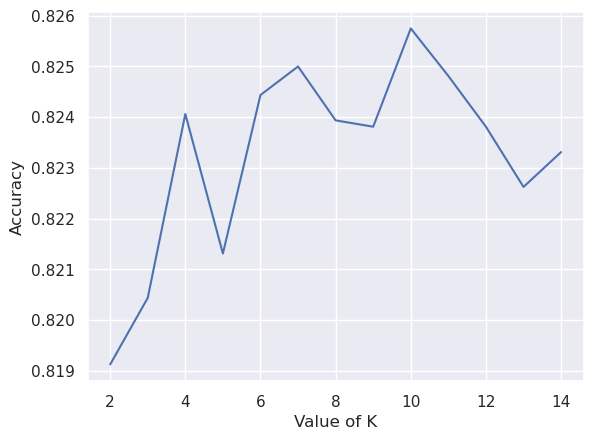

In [54]:
plt.plot(range_k,scores_list)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")

In [55]:
# On récupère le classifieur le plus performant
knn = neighbors.KNeighborsClassifier(5, weights='distance', p=1)
knn.fit(xtrain, ytrain)

# On récupère les prédictions sur les données test
# print(xtest)
predicted = knn.predict(xtest)
score = knn.score(xtest, ytest)
# print(predicted)

# On selectionne un echantillon de 12 images au hasard
select = np.random.randint(xtest.shape[0], size=10)
# print(select.shape)
# On affiche les images avec la prédiction associée
# fig,ax = plt.subplots(3,4)

for index, value in enumerate(select):
    print("Valeur :", value)
    print("Xtest :", xtest[value])
    print("Ytest :", ytest[value])
    print("Prédiction Nutri-score :", predicted[value])
    break
    

Valeur : 6381


KeyError: 6381

In [ ]:
# # on récupère les données mal prédites 
# misclass = (ytest != predicted)
# misclass_xtest = xtest[misclass]
# misclass_predicted = predicted[misclass]

# # on sélectionne un échantillon de ces images
# select = np.random.randint(misclass_xtest.shape[0], size=10)

# # on affiche les images et les prédictions (erronées) associées à ces images
# for index, value in enumerate(select):
#     print("Valeur en énergie :", value)
#     print("Prédiction Nutri-score :", misclass_predicted[value])

In [ ]:
from sklearn.model_selection import GridSearchCV
estimator_KNN = neighbors.KNeighborsClassifier(algorithm='auto')
parameters_KNN = {
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')}
                   
# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

In [ ]:
KNN_1=grid_search_KNN.fit(xtrain, ytrain)
y_pred_KNN1 =KNN_1.predict(xtest)

In [ ]:
print(grid_search_KNN.best_params_ )
print('Best Score - KNN:', grid_search_KNN.best_score_ )